# 04 - Multi-layer NN per Ticker

This notebook trains a multi-layer neural network on each ticker to evaluate performance improvement from increased model depth.


Training AAPL...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 13: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 18: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


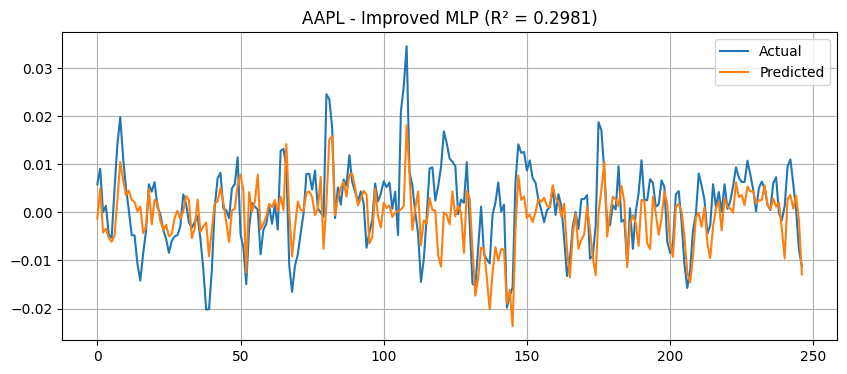


Training MSFT...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 21: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 26: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


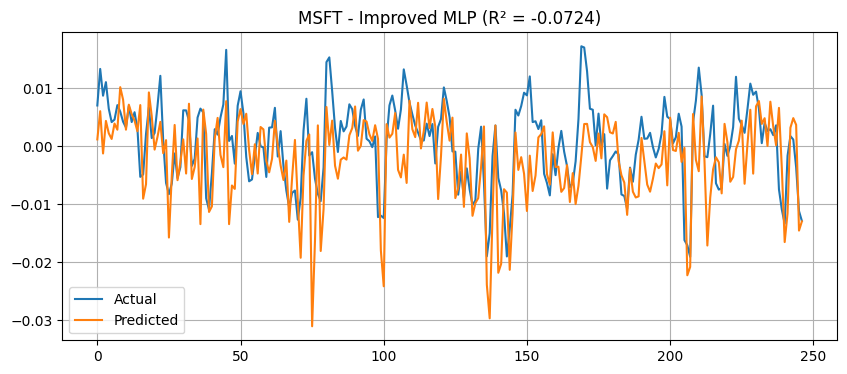


Training JPM...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 20: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 25: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


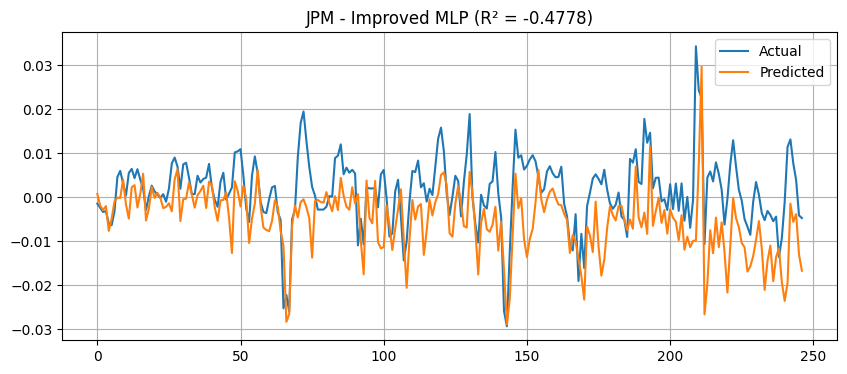


Training BAC...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 17: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


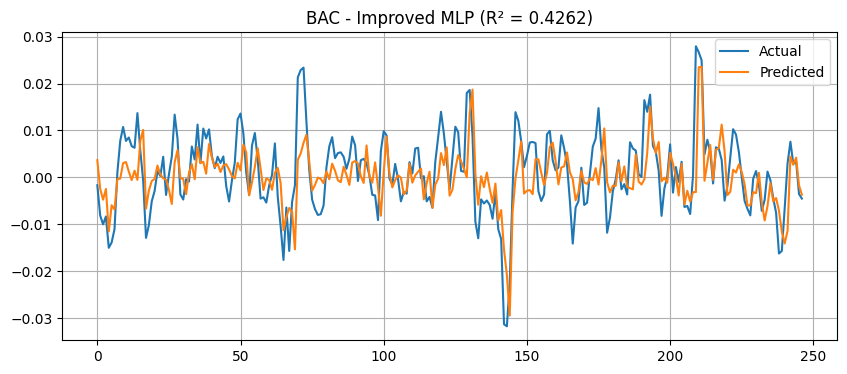


Training XOM...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 17: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


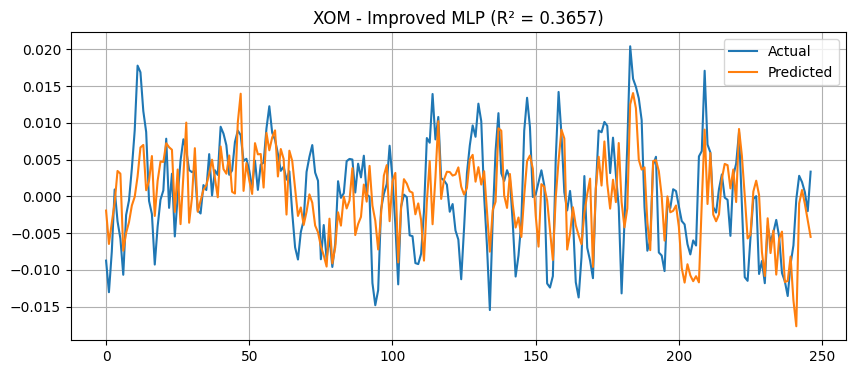


Training CVX...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 33: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 38: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


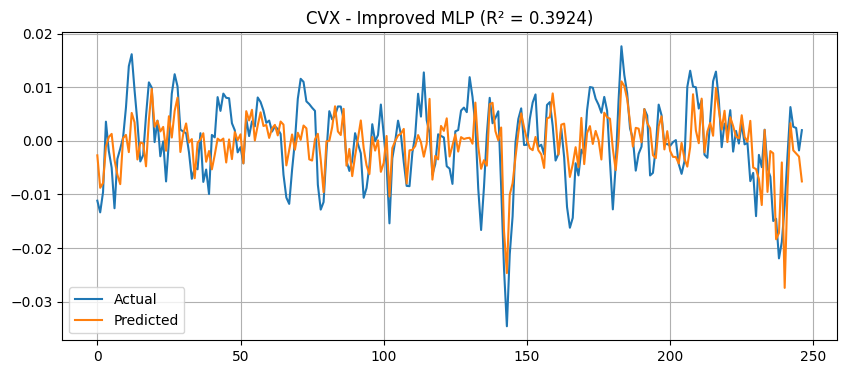


SUMMARY
AAPL: MSE = 0.000048, R² = 0.2981
MSFT: MSE = 0.000053, R² = -0.0724
JPM: MSE = 0.000093, R² = -0.4778
BAC: MSE = 0.000042, R² = 0.4262
XOM: MSE = 0.000032, R² = 0.3657
CVX: MSE = 0.000035, R² = 0.3924


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import os

# Reproducibility
import random
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

tickers = ['AAPL', 'MSFT', 'JPM', 'BAC', 'XOM', 'CVX']
results = {}

for ticker in tickers:
    print(f"\nTraining {ticker}...")
    df = pd.read_csv(f'../data/processed/{ticker}_processed.csv', index_col='Date', parse_dates=True)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # === Feature Engineering ===
    df['Return'] = df['Close'].pct_change()

    for i in range(1, 6):
        df[f'Lag_{i}'] = df['Return'].shift(i)

    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

    delta = df['Close'].diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = -delta.clip(upper=0).rolling(14).mean()
    rs = gain / (loss.replace(0, np.finfo(float).eps))
    df['RSI'] = 100 - (100 / (1 + rs))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Volatility
    df['Volatility_10'] = df['Return'].rolling(window=10).std()

    # Volume features (if available)
    if 'Volume' in df.columns:
        df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
        df['Volume_Change'] = df['Volume'].pct_change()
        df['Volume_SMA_5'] = df['Volume'].rolling(5).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_5']

    # === Target: 3-day smoothed forward log return ===
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Target'] = df['LogReturn'].shift(-1).rolling(3).mean()

    df = df.dropna()

    # Drop unused columns
    X = df.drop(columns=['Return', 'Close', 'Target', 'LogReturn'])
    y = df['Target']

    # === Normalize target ===
    y_mean, y_std = y.mean(), y.std()
    y_train, y_test = train_test_split(y, shuffle=False, test_size=0.2)
    y_train_norm = (y_train - y_mean) / y_std
    y_test_norm = (y_test - y_mean) / y_std

    # === Train-test split ===
    X_train, X_test = train_test_split(X, shuffle=False, test_size=0.2)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # === Model Architecture ===
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(1e-4), input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # === Callbacks ===
    early_stop = EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-5, verbose=1)

    model.fit(X_train_scaled, y_train_norm, validation_split=0.2, epochs=200, verbose=0,
              callbacks=[early_stop, reduce_lr])

    # Save model
    os.makedirs('../models/saved_model', exist_ok=True)
    model.save(f'../models/saved_model/{ticker}_improved_nn.h5')

    # === Predict and Evaluate ===
    y_pred_norm = model.predict(X_test_scaled).flatten()
    y_pred = y_pred_norm * y_std + y_mean
    y_test_actual = y_test.values

    mse = mean_squared_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)
    results[ticker] = (mse, r2)

    # Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_actual, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"{ticker} - Improved MLP (R² = {r2:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Summary Output ===
print("\nSUMMARY")
for ticker, (mse, r2) in results.items():
    print(f"{ticker}: MSE = {mse:.6f}, R² = {r2:.4f}")
